# PyTorch starter - FasterRCNN Inference

```
********************************************************************************************
         __           _                                _       _                 _    
        / _|         | |                              | |     | |               | |   
       | |_ ___  _ __| | ___ __ ___  _   _ _ __   ___ | |_ ___| |__   ___   ___ | | __
       |  _/ _ \| '__| |/ / '_ ` _ \| | | | '_ \ / _ \| __/ _ \ '_ \ / _ \ / _ \| |/ /
       | || (_) | |  |   <| | | | | | |_| | | | | (_) | ||  __/ |_) | (_) | (_) |   < 
       |_| \___/|_|  |_|\_\_| |_| |_|\__, |_| |_|\___/ \__\___|_.__/ \___/ \___/|_|\_\
                                      __/ |                                           
                                     |___/                                    
********************************************************************************************
                    If you'd like to publish a forked version of this notebook,
                            please do not remove this notice.
--------------------------------------------------------------------------------------------
                                      Original Notebook
--------------------------------------------------------------------------------------------
Title...............: VinBigData FasterRCNN Pytorch - Inference
Link................: https://kaggle.com/pestipeti/vinbigdata-fasterrcnn-pytorch-inference
Author..............: Peter (https://kaggle.com/pestipeti)
Version.............: 8


--------------------------------------------------------------------------------------------
                                          Fork #1                   
--------------------------------------------------------------------------------------------
Title...............: [Your notebook's title]
```


You can find the [train notebook here](https://www.kaggle.com/pestipeti/vinbigdata-fasterrcnn-pytorch-train)

- FasterRCNN from torchvision
- Uses Resnet50+FPN backbone
- Original Dicom Images (resized to 512)

In [1]:
import pandas as pd
import numpy as np
import cv2
import os
import re
import pydicom
import warnings

from PIL import Image

import albumentations as A
from albumentations.pytorch.transforms import ToTensorV2

import torch
import torchvision

from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
from torchvision.models.detection import FasterRCNN
from torchvision.models.detection.rpn import AnchorGenerator

from torch.utils.data import DataLoader, Dataset
from torch.utils.data.sampler import SequentialSampler

from matplotlib import pyplot as plt

warnings.filterwarnings("ignore")

DIR_INPUT = '/home/ubuntu/data_dicom'
DIR_TRAIN = f'{DIR_INPUT}/train'
DIR_TEST = f'{DIR_INPUT}/test'
DIR_WEIGHTS = '/home/ubuntu/data_dicom/weights'

WEIGHTS_FILE = f'{DIR_WEIGHTS}/model_state_epoch_9.pth'

In [2]:
# test_df 전체 데이터 정보 불러오기
test_df = pd.read_csv(f'{DIR_INPUT}/sample_submission.csv')
test_df
# classID confidence xmin ymin xmax ymax

,image_id,PredictionString
0,002a34c58c5b758217ed1f584ccbcfe9,14 1 0 0 1 1
1,004f33259ee4aef671c2b95d54e4be68,14 1 0 0 1 1
2,008bdde2af2462e86fd373a445d0f4cd,14 1 0 0 1 1
3,009bc039326338823ca3aa84381f17f1,14 1 0 0 1 1
4,00a2145de1886cb9eb88869c85d74080,14 1 0 0 1 1
...,...,...
2995,ff91fb82429a27521bbec8569b041f02,14 1 0 0 1 1
2996,ff9fcc4087ed5e941209aa3fa948e364,14 1 0 0 1 1
2997,ffaa288c8abca300974f043b57d81521,14 1 0 0 1 1
2998,ffc441e0c8b7153844047483a577e7c3,14 1 0 0 1 1


# 현재 가지고있는 test 파일만 돌려보기

In [3]:
# 현재 가지고있는 test 데이터로만 활용(원활한 학습을 위해 데이터량줄임)
import os
file_list = os.listdir(DIR_TEST)
print(len(file_list))

file_name = []
for file in file_list:
    if file.count(".") == 1: 
        name = file.split('.')[0]
        file_name.append(name)
    else:
        for k in range(len(file)-1,0,-1):
            if file[k]=='.':
                file_name.append(file[:k])
                break
                
print(len(file_name))

3000
3000


In [4]:
test_df2 = test_df[test_df['image_id'].isin(file_name)]
print(len(test_df2))
test_df= test_df2

3000


In [5]:
test_df.head()

,image_id,PredictionString
0,002a34c58c5b758217ed1f584ccbcfe9,14 1 0 0 1 1
1,004f33259ee4aef671c2b95d54e4be68,14 1 0 0 1 1
2,008bdde2af2462e86fd373a445d0f4cd,14 1 0 0 1 1
3,009bc039326338823ca3aa84381f17f1,14 1 0 0 1 1
4,00a2145de1886cb9eb88869c85d74080,14 1 0 0 1 1


# vinBigDataset

In [6]:
# VinBigDataset ...!!!

class VinBigTestDataset(Dataset):
    
    # 초기화
    def __init__(self, dataframe, image_dir, transforms=None):
        super().__init__()
        
        self.image_ids = dataframe["image_id"].unique()
        self.df = dataframe
        self.image_dir = image_dir
        self.transforms = transforms
     
    # 인덱스를 인자로 받아 훈련(혹은, 검증)에서 사용할 샘플 데이터 튜플을 반환하는 메소드
    # 샘플과 레이블(정수인덱스)로 이루어진 아이템 반환
    def __getitem__(self, index):
        
        image_id = self.image_ids[index]
        records = self.df[(self.df['image_id'] == image_id)]
        records = records.reset_index(drop=True)

        dicom = pydicom.dcmread(f"{self.image_dir}/{image_id}.dicom")
        # pixel_array
        image = dicom.pixel_array
        # Rescale Intercept
        intercept = dicom.RescaleIntercept if "RescaleIntercept" in dicom else 0.0
        # Rescale Slope
        slope = dicom.RescaleSlope if "RescaleSlope" in dicom else 1.0
        
        if slope != 1:
            image = slope * image.astype(np.float64)
            image = image.astype(np.int16)
            
        image += np.int16(intercept)        
        
        image = np.stack([image, image, image])
        image = image.astype('float32')
        image = image - image.min()
        image = image / image.max()
        image = image * 255.0
        # 여기서 img.transpose(1, 0, 2)는 원래 height, width, layer였던 구조를 width, height, layer로 바꾸겠다는 말입니다. layer는 그대로죠.
        image = image.transpose(1,2,0)
       
        # 이미지를 파이토치 텐서로 변환 torchvision.transforms
        if self.transforms:
            sample = {
                'image': image,
            }
            sample = self.transforms(**sample)
            image = sample['image']

        return image, image_id
    
    # 데이터셋의 아이템수
    def __len__(self):
        return self.image_ids.shape[0]

In [7]:
# Albumentations
def get_test_transform():
    return A.Compose([
        # FasterRCNN will normalize.
        A.Normalize(mean=(0, 0, 0), std=(1, 1, 1), max_pixel_value=255.0, p=1.0),
        # ToTesorV2는 ToTensor와 마찬가지로 tensor형변환, channel dimension을 첫번째 차원으로 가져오는 역할을 하지만 min_max scaling은 하지 않는다는 것을 명심하자.
        ToTensorV2(p=1.0)
    ])

In [8]:
# load a model; pre-trained on COCO
model = torchvision.models.detection.fasterrcnn_resnet50_fpn(
    pretrained=False,
    pretrained_backbone=False,
    min_size=512,
    max_size=853
)

In [9]:
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
# no finding 포함 15개 클래스
num_classes = 15

# get number of input features for the classifier
in_features = model.roi_heads.box_predictor.cls_score.in_features

# replace the pre-trained head with a new one
model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)

# Load the trained weights
model.load_state_dict(torch.load(WEIGHTS_FILE, map_location=device))
# nn.Module에서 train time과 eval time에서 수행하는 다른 작업을 수행할 수 있도록 switching 하는 함수라고 한다.
# .eval() 함수는 evaluation 과정에서 사용하지 않아야 하는 layer들을 알아서 off 시키도록 하는 함수인 셈이다.
# model.eval()의 역할은 약간 다르다. 현재(2019년) 시점에서는 모델링 시 training과 inference시에 다르게 동작하는 layer들이 존재한다. 예를 들면, Dropout layer는 학습시에는 동작해야하지만, inference시에는 동작하지 않는 것과 같은 예시를 들 수 있다. BatchNorm같은 경우도 마찬가지다.
#사실상 model.eval()는 이런 layer들의 동작을 inference(eval) mode로 바꿔준다는 목적으로 사용된다. 따라서, 우리가 보통 원하는 모델의 동작을 위해서는 위의 두 가지를 모두 사용해야하는 것이 맞다.
model.eval()
# 모델에 사용되는 모든 입력 Tensor들에 대해 input = input.to(device) 을 호출해야 합니다.
x = model.to(device)

In [10]:
test_df

,image_id,PredictionString
0,002a34c58c5b758217ed1f584ccbcfe9,14 1 0 0 1 1
1,004f33259ee4aef671c2b95d54e4be68,14 1 0 0 1 1
2,008bdde2af2462e86fd373a445d0f4cd,14 1 0 0 1 1
3,009bc039326338823ca3aa84381f17f1,14 1 0 0 1 1
4,00a2145de1886cb9eb88869c85d74080,14 1 0 0 1 1
...,...,...
2995,ff91fb82429a27521bbec8569b041f02,14 1 0 0 1 1
2996,ff9fcc4087ed5e941209aa3fa948e364,14 1 0 0 1 1
2997,ffaa288c8abca300974f043b57d81521,14 1 0 0 1 1
2998,ffc441e0c8b7153844047483a577e7c3,14 1 0 0 1 1


In [11]:
# batch sampler 로 묶인 이후에는, collate_fn을 호출해 batch로 묶는다.
def collate_fn(batch):
    return tuple(zip(*batch))

test_dataset = VinBigTestDataset(test_df, DIR_TEST, get_test_transform())

test_data_loader = DataLoader(
    test_dataset,
    batch_size=8,
    shuffle=False,
    num_workers=4,
    drop_last=False,
    collate_fn=collate_fn
)

In [12]:
import torch, gc
gc.collect()
torch.cuda.empty_cache()

In [13]:
def format_prediction_string(labels, boxes, scores):
    pred_strings = []
    for j in zip(labels, scores, boxes):
        pred_strings.append("{0} {1:.4f} {2} {3} {4} {5}".format(
            j[0], j[1], j[2][0], j[2][1], j[2][2], j[2][3]))
        # labels scores box_xmin  box_xmax box_ymin box_ymax     
    return " ".join(pred_strings)

In [14]:
detection_threshold = 0.5
results = []

# Pytorch는 autograd engine을 꺼버린다. 
# 이 말은 더 이상 자동으로 gradient를 트래킹하지 않는다는 말
# 주된 목적은 autograd를 끔으로써 메모리 사용량을 줄이고 연산 속도를 높히기 위함이다.
# 그래서 일반적으로 inference를 진행할 때는 torch.no_grad() with statement로 감싼다는 사실을 알면 된다.
try:
    with torch.no_grad():
        for images, image_ids in test_data_loader:
            images = list(image.to(device) for image in images)
            outputs = model(images)

            for i, image in enumerate(images):

                image_id = image_ids[i]

                result = {
                    'image_id': image_id,
                    'PredictionString': '14 1.0 0 0 1 1'
                }

                boxes = outputs[i]['boxes'].data.cpu().numpy()
                labels = outputs[i]['labels'].data.cpu().numpy()
                scores = outputs[i]['scores'].data.cpu().numpy()

                if len(boxes) > 0:
                    # 라벨 -1 씩 SHIFT
                    labels = labels - 1
                    # no finding 이 -1에서 14로 이동!
                    labels[labels == -1] = 14
                    # 0.5 보다 confidence 높은걸로 선택함
                    selected = scores >= detection_threshold

                    boxes = boxes[selected].astype(np.int32)
                    scores = scores[selected]
                    labels = labels[selected]
    
                    # 0.5 보다 confidence 높은 박스가 있다는 의미
                    if len(boxes) > 0:
                        result = {
                            'image_id': image_id,
                            'PredictionString': format_prediction_string(labels, boxes, scores)
                        }
                # result list를 계속 append!
                results.append(result)
except ValueError as e:
    print(e)
    print(image_id)

In [15]:
results[0:2]

[{'image_id': '002a34c58c5b758217ed1f584ccbcfe9',
  'PredictionString': '14 1.0 0 0 1 1'},
 {'image_id': '004f33259ee4aef671c2b95d54e4be68',
  'PredictionString': '0 0.7332 1208 582 1538 933 0 0.5516 1058 1277 1920 1835'}]

In [16]:
test_df = pd.DataFrame(results, columns=['image_id', 'PredictionString'])
test_df

,image_id,PredictionString
0,002a34c58c5b758217ed1f584ccbcfe9,14 1.0 0 0 1 1
1,004f33259ee4aef671c2b95d54e4be68,0 0.7332 1208 582 1538 933 0 0.5516 1058 1277 ...
2,008bdde2af2462e86fd373a445d0f4cd,14 1.0 0 0 1 1
3,009bc039326338823ca3aa84381f17f1,14 1.0 0 0 1 1
4,00a2145de1886cb9eb88869c85d74080,14 1.0 0 0 1 1
...,...,...
2995,ff91fb82429a27521bbec8569b041f02,14 1.0 0 0 1 1
2996,ff9fcc4087ed5e941209aa3fa948e364,14 1.0 0 0 1 1
2997,ffaa288c8abca300974f043b57d81521,14 1.0 0 0 1 1
2998,ffc441e0c8b7153844047483a577e7c3,14 1.0 0 0 1 1


In [17]:
sample = images[1].permute(1,2,0).cpu().numpy()
boxes = outputs[1]['boxes'].data.cpu().numpy()
scores = outputs[1]['scores'].data.cpu().numpy()

boxes = boxes[scores >= detection_threshold].astype(np.int32)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


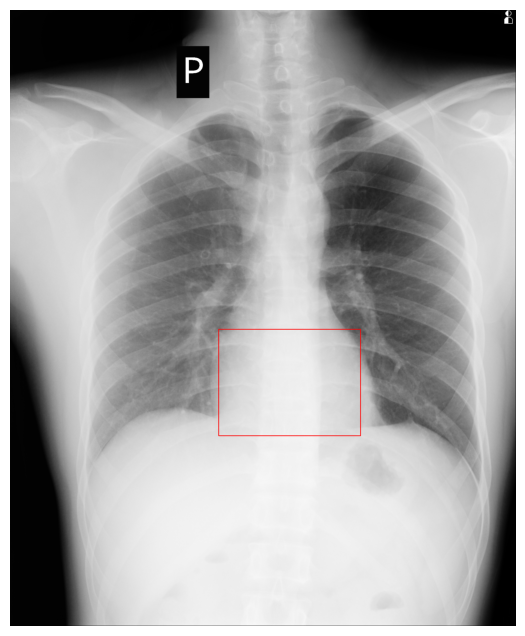

In [18]:
fig, ax = plt.subplots(1, 1, figsize=(16, 8))

for box in boxes:
    cv2.rectangle(sample,
                  (box[0], box[1]),
                  (box[2], box[3]),
                  (220, 0, 0), 2)
    
ax.set_axis_off()
ax.imshow(sample)

In [19]:
test_df.to_csv('submission.csv', index=False)